This notebook creates the final datasets from the preprocessed dataset. It splits the data into train, val and test sets and applies various sampling methods for the train set: no_sampling, upsampling and downsampling

Config

In [2]:
INPUT_FILE_NAME = "V2_preprocessed"
OUTPUT_FOLDER_NAME = "final_datasets"
TEST_SIZE = 0.2
RANDOM_STATE = 42
VAL_SIZE = 0.125
SAMPLING_MINORITY_RATIO = 0.3

## Setup

Imports

In [3]:
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from sklearn.utils import resample
from pathlib import Path
import numpy as np
import random
import json
from sklearn.preprocessing import StandardScaler

Load the dataset

In [4]:
def find_project_root(marker=".gitignore"):
    """
    walk up from the current working directory until a directory containing the
    specified marker (e.g., .gitignore) is found.
    """
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent.resolve()
    raise FileNotFoundError(
        f"Project root marker '{marker}' not found starting from {current}"
    )

In [5]:
project_root = find_project_root()
print("Project root:", project_root)
if project_root not in sys.path:
    sys.path.append(project_root)

df_path = f"{project_root}/dataset/{INPUT_FILE_NAME}.parquet"
try:
    df = pd.read_parquet(df_path)
except Exception as e:
    sys.exit(f"Error loading dataset from {df_path}: {e}")

Project root: /Users/aidend/Developer/ds_uni/dl-sepsis-prediction


In [6]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

## Helper Functions

In [7]:
def over_under_sample(df, method="oversample", minority_ratio=0.3):
    """
    Balances the dataset at the patient level.

    Each patient's overall sepsis label is taken as the maximum value
    (if any record shows sepsis, the patient is marked as septic).

    We then either oversample the septic (minority) patients or undersample
    the non-septic (majority) patients to change the ratio.

    In the final dataset, each copy of a patient gets a unique ID so that
    oversampled patients appear as separate instances.
    """
    # Create a patient-level summary with one record per patient.
    patient_df = df.groupby("patient_id")["SepsisLabel"].max().reset_index()

    # Count patients in each group.
    counts = patient_df["SepsisLabel"].value_counts()
    majority_class = counts.idxmax()
    minority_class = counts.idxmin()

    # Split the patients into majority and minority groups.
    majority_patients = patient_df[patient_df["SepsisLabel"] == majority_class]
    minority_patients = patient_df[patient_df["SepsisLabel"] == minority_class]

    # Resample based on the chosen method.
    if method == "oversample":
        # Duplicate minority patients to reach desired ratio.
        n_desired_minority = int(
            (minority_ratio * len(majority_patients)) / (1 - minority_ratio)
        )
        minority_upsampled = resample(
            minority_patients,
            replace=True,
            n_samples=n_desired_minority,
            random_state=RANDOM_STATE,
        )
        balanced_patient_df = pd.concat([majority_patients, minority_upsampled])
    elif method == "undersample":
        # Remove some majority patients to reach desired ratio.
        n_desired_majority = int(
            ((1 - minority_ratio) / minority_ratio) * len(minority_patients)
        )
        majority_downsampled = resample(
            majority_patients,
            replace=False,
            n_samples=n_desired_majority,
            random_state=RANDOM_STATE,
        )
        balanced_patient_df = pd.concat([majority_downsampled, minority_patients])
    else:
        raise ValueError("Method must be 'oversample' or 'undersample'")

    # Rebuild the full dataset with patient records.
    # If a patient appears more than once due to resampling,
    # assign a new unique patient ID to each duplicate.
    final_dfs = []
    patient_occurrences = {}

    for pid in balanced_patient_df["patient_id"]:
        # Get all records for this patient.
        patient_records = df[df["patient_id"] == pid].copy()
        # Count how many times this patient has been added.
        if pid in patient_occurrences:
            patient_occurrences[pid] += 1
            # Create a new unique ID by appending a suffix.
            new_pid = pid * 1000 + patient_occurrences[pid]
            patient_records["patient_id"] = new_pid
        else:
            # first occurrence, keep original ID
            patient_occurrences[pid] = 0
        final_dfs.append(patient_records)

    balanced_df = pd.concat(final_dfs, ignore_index=True)

    return balanced_df

## Datasets and Processing

Split dataset into train, val, and test



In [8]:
patient_labels = df.groupby("patient_id")["SepsisLabel"].max()

train_val_patients, test_patients = train_test_split(
    patient_labels.index,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=patient_labels,  # Stratify by patient-level labels
)

train_val_df = df[df["patient_id"].isin(train_val_patients)]
test_df = df[df["patient_id"].isin(test_patients)]

train_patients, val_patients = train_test_split(
        train_val_patients,
        test_size=VAL_SIZE,
        random_state=RANDOM_STATE,
        stratify=patient_labels[train_val_patients],
)

train_df = train_val_df[train_val_df["patient_id"].isin(train_patients)]
val_df = train_val_df[train_val_df["patient_id"].isin(val_patients)]

In [9]:
# print the range of ICULOS values
print("ICULOS (max): ", train_df["ICULOS"].max(), "ICULOS (min): ", train_df["ICULOS"].min())

# print the range of HospAdmTime values
print("HospAdmTime (max): ", train_df["HospAdmTime"].max(), "HospAdmTime (min): ", train_df["HospAdmTime"].min())


ICULOS (max):  336 ICULOS (min):  1
HospAdmTime (max):  23.99 HospAdmTime (min):  -5366.86


In [11]:
print(train_df["patient_id"].unique())
# print min and max of the patient ids
print(np.min(train_df["patient_id"]), np.max(train_df["patient_id"]))


[    1     3     4 ... 40333 40334 40335]
1 40335


ICULOS (max):  336 ICULOS (min):  1
HospAdmTime (max):  23.99 HospAdmTime (min):  -5366.86


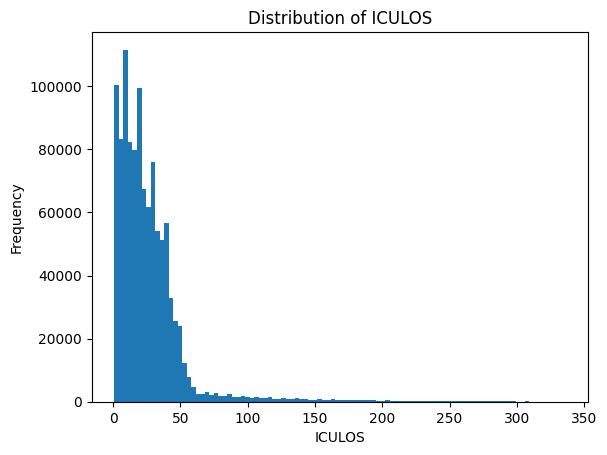

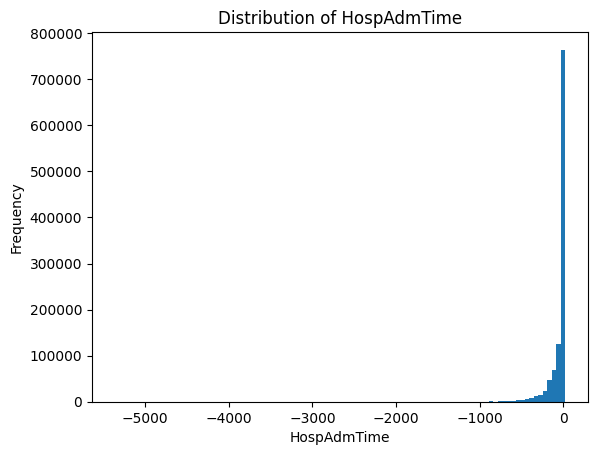

In [12]:
# print the range of values for ICULOS
print("ICULOS (max): ", train_df["ICULOS"].max(), "ICULOS (min): ", train_df["ICULOS"].min())

# print the range of values for HospAdmTime
print("HospAdmTime (max): ", train_df["HospAdmTime"].max(), "HospAdmTime (min): ", train_df["HospAdmTime"].min())

import matplotlib.pyplot as plt
# plot the distribution of the ICULOS
plt.hist(train_df["ICULOS"], bins=100)
plt.title("Distribution of ICULOS")
plt.xlabel("ICULOS")
plt.ylabel("Frequency")
plt.show()

# plot the distribution of the HospAdmTime
plt.hist(train_df["HospAdmTime"], bins=100)
plt.title("Distribution of HospAdmTime")
plt.xlabel("HospAdmTime")
plt.ylabel("Frequency")
plt.show()

Scale the dataset

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle

def scale_dfs(train_df, val_df, test_df, labels=["SepsisLabel"], eps=1e-6):
    # Identify feature columns
    feature_cols = [c for c in train_df.columns if c not in labels]
    #print location of patient_id column
    print(train_df[feature_cols].columns.get_loc("patient_id"))
    print(train_df[feature_cols].shape)
    # Fit scaler on train features
    scaler = StandardScaler().fit(train_df[feature_cols])
    print(train_df[feature_cols].shape)
    # Apply scaling
    def apply_scaling(df):
        df_scaled = df.copy()
        df_scaled[feature_cols] = scaler.transform(df[feature_cols])
        return df_scaled

    train_scaled = apply_scaling(train_df)
    val_scaled   = apply_scaling(val_df)
    test_scaled  = apply_scaling(test_df)
    
    # patient_id_index = train_df.columns.get_loc("patient_id")
    # with open(f"{project_root}/dataset/{OUTPUT_FOLDER_NAME}/patient_id_index.pkl", "wb") as f:
    #     pickle.dump(patient_id_index, f)

    # df_shape = train_df[feature_cols].shape
    # with open(f"{project_root}/dataset/{OUTPUT_FOLDER_NAME}/df_shape.pkl", "wb") as f:
    #     pickle.dump(df_shape, f)


    # --- TEST: mean ≈ 0 and std ≈ 1 on train_scaled ---
    means = train_scaled[feature_cols].mean()
    stds  = train_scaled[feature_cols].std(ddof=0)  # population std to match StandardScaler

    # Check each column
    mean_pass = (means.abs() < eps).all()
    std_pass  = ((stds - 1).abs() < eps).all()

    # Print detailed results
    print("Scaling test results on train set:")
    df_test = pd.DataFrame({
        'mean': means.round(6),
        'std':  stds.round(6),
        'mean_ok': (means.abs() < eps),
        'std_ok':  ((stds - 1).abs() < eps)
    })
    print(df_test)
    print(f"\nAll means ≈ 0? {'✅' if mean_pass else '❌'}")
    print(f"All stds ≈ 1?  {'✅' if std_pass else '❌'}\n")
    
    # Save the scaler
    scaler_path = f"{project_root}/dataset/{OUTPUT_FOLDER_NAME}/scaler.pkl"
    with open(scaler_path, "wb") as f:
        pickle.dump(scaler, f)

    return train_scaled, val_scaled, test_scaled



In [15]:
train_df, val_df, test_df = scale_dfs(train_df, val_df, test_df)

38
(1085891, 108)
(1085891, 108)
Scaling test results on train set:
                  mean  std  mean_ok  std_ok
HR                 0.0  1.0     True    True
O2Sat             -0.0  1.0     True    True
Temp              -0.0  1.0     True    True
SBP                0.0  1.0     True    True
MAP                0.0  1.0     True    True
...                ...  ...      ...     ...
Resp_min_6h        0.0  1.0     True    True
Resp_mean_6h      -0.0  1.0     True    True
Resp_median_6h     0.0  1.0     True    True
Resp_std_6h        0.0  1.0     True    True
Resp_diff_std_6h  -0.0  1.0     True    True

[108 rows x 4 columns]

All means ≈ 0? ✅
All stds ≈ 1?  ✅



In [27]:
# stop execution here make an error
raise Exception("Stop execution here")

Exception: Stop execution here

In [12]:
patient_id_index = train_df.columns.get_loc("patient_id")
#patient ids
patient_ids = train_df.iloc[:, patient_id_index]
print(patient_ids.head())


0    1
1    1
2    1
3    1
4    1
Name: patient_id, dtype: int64


In [13]:
print(train_df["patient_id"].nunique())

28234


In [14]:
train_df.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,MAP_mean_6h,MAP_median_6h,MAP_std_6h,MAP_diff_std_6h,Resp_max_6h,Resp_min_6h,Resp_mean_6h,Resp_median_6h,Resp_std_6h,Resp_diff_std_6h
0,1.022785,-1.887699,-0.069259,0.198027,0.343221,0.296926,1.192701,-0.536513,0.271187,-0.978945,...,0.389594,0.408017,0.404621,0.981094,0.534639,2.139701,1.426581,1.415296,0.940694,1.192096
1,0.727362,-0.708370,-0.069259,-1.120443,-0.453785,0.296926,0.063230,-0.536513,0.271187,-0.978945,...,-0.067477,-0.044764,0.404621,0.981094,0.534639,0.765886,0.758024,0.764857,0.940694,1.192096
2,0.264725,0.609247,-0.069259,-0.071440,0.206996,0.296926,0.656412,-0.536513,0.271187,-0.978945,...,0.032798,0.253237,-0.031841,0.981094,0.534639,0.765886,0.769249,0.797620,0.267715,1.192096
3,0.322555,-0.708370,-0.069259,-0.071440,0.372036,0.296926,2.238232,-0.536513,14.432587,-0.978945,...,0.130259,0.330627,-0.155709,0.349022,1.489872,0.765886,1.243017,1.106458,1.301121,1.505821
4,1.074340,-2.849497,-0.069259,-0.071440,0.537076,0.296926,1.150731,-0.536513,0.271187,-0.978945,...,0.226595,0.408017,-0.164923,0.062996,1.489872,0.765886,1.269793,1.366956,0.949284,1.421386


In [32]:
# check the number of datapoints that are outliers in the whole dataset
print(train_df.shape[0])
print(train_df.shape[0] - train_df.dropna().shape[0])


1085891
0


In [15]:
# check the scaler is working ie the mean and std of the train set are 0 and 1
print(train_df.mean())
print(train_df.std())

HR                  1.349512e-16
O2Sat              -1.549835e-14
Temp               -2.984082e-14
SBP                 1.213409e-15
MAP                 9.135644e-16
                        ...     
Resp_min_6h         1.314427e-15
Resp_mean_6h       -1.923395e-15
Resp_median_6h      2.073266e-15
Resp_std_6h         3.739688e-16
Resp_diff_std_6h   -4.728005e-16
Length: 109, dtype: float64
HR                  1.0
O2Sat               1.0
Temp                1.0
SBP                 1.0
MAP                 1.0
                   ... 
Resp_min_6h         1.0
Resp_mean_6h        1.0
Resp_median_6h      1.0
Resp_std_6h         1.0
Resp_diff_std_6h    1.0
Length: 109, dtype: float64


Save the train (no sample), test and val sets

In [16]:
output_folder = f"{project_root}/dataset/{OUTPUT_FOLDER_NAME}"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
val_df.to_parquet(f"{output_folder}/val.parquet")
test_df.to_parquet(f"{output_folder}/test.parquet")
train_df.to_parquet(f"{output_folder}/no_sampling_train.parquet")

Create the sampled datasets: one for undersampling and one for oversampling

In [17]:
upsampled_train_df = over_under_sample(
    df=train_df.copy(), method="oversample", minority_ratio=SAMPLING_MINORITY_RATIO
)
undersampled_train_df = over_under_sample(
    df=train_df.copy(), method="undersample", minority_ratio=SAMPLING_MINORITY_RATIO
)

#Save the sampled datasets
upsampled_train_df.to_parquet(f"{output_folder}/oversampled_train.parquet")
undersampled_train_df.to_parquet(f"{output_folder}/undersampled_train.parquet")


## Analysis

Checking the balance ratio for the datasets

In [18]:
def get_dataset_stats(df, name):
    total_patients = df["patient_id"].nunique()
    patient_labels = df.groupby("patient_id")["SepsisLabel"].max()

    non_sepsis = (patient_labels == 0).sum()
    sepsis = (patient_labels == 1).sum()

    non_sepsis_pct = non_sepsis / total_patients * 100
    sepsis_pct = sepsis / total_patients * 100

    imbalance_ratio = non_sepsis / sepsis if sepsis > 0 else float("inf")

    return {
        "Dataset": name,
        "Total Patients": total_patients,
        "Non-Sepsis Patients": non_sepsis,
        "Non-Sepsis %": f"{non_sepsis_pct:.2f}%",
        "Sepsis Patients": sepsis,
        "Sepsis %": f"{sepsis_pct:.2f}%",
        "Imbalance Ratio": f"{imbalance_ratio:.2f}",
    }

datasets = [
    (train_df, "No Sampling (Train)"),
    (val_df, "Validation"),
    (test_df, "Test"),
    (upsampled_train_df, "Oversampled (Train)"),
    (undersampled_train_df, "Undersampled (Train)"),
]

results = []
for df, name in datasets:
    results.append(get_dataset_stats(df, name))

# Create and display the results table
results_df = pd.DataFrame(results)
display(results_df)

,Dataset,Total Patients,Non-Sepsis Patients,Non-Sepsis %,Sepsis Patients,Sepsis %,Imbalance Ratio
0,No Sampling (Train),28234,26181,92.73%,2053,7.27%,12.75
1,Validation,4034,3741,92.74%,293,7.26%,12.77
2,Test,8068,7482,92.74%,586,7.26%,12.77
3,Oversampled (Train),37395,26175,70.00%,11220,30.00%,2.33
4,Undersampled (Train),6843,4790,70.00%,2053,30.00%,2.33


Features of the datasets

In [19]:
from pprint import pprint
pprint(train_df.columns.tolist())

['HR',
 'O2Sat',
 'Temp',
 'SBP',
 'MAP',
 'DBP',
 'Resp',
 'EtCO2',
 'BaseExcess',
 'HCO3',
 'FiO2',
 'pH',
 'PaCO2',
 'SaO2',
 'AST',
 'BUN',
 'Alkalinephos',
 'Calcium',
 'Chloride',
 'Creatinine',
 'Bilirubin_direct',
 'Glucose',
 'Lactate',
 'Magnesium',
 'Phosphate',
 'Potassium',
 'Bilirubin_total',
 'TroponinI',
 'Hct',
 'Hgb',
 'PTT',
 'WBC',
 'Fibrinogen',
 'Platelets',
 'Age',
 'Gender',
 'HospAdmTime',
 'ICULOS',
 'SepsisLabel',
 'patient_id',
 'SOFA_Creatinine',
 'SOFA_Platelets',
 'SOFA_Bilirubin_total',
 'SOFA_SaO2_FiO2',
 'SOFA_score',
 'NEWS_HR_score',
 'NEWS_Resp_score',
 'NEWS_Temp_score',
 'NEWS_SBP_score',
 'NEWS_O2Sat_score',
 'NEWS_FiO2_score',
 'NEWS_score',
 'qSOFA_Resp_score',
 'qSOFA_SBP_score',
 'qSOFA_score',
 'Shock_Index',
 'Bilirubin_Ratio',
 'SOFA_score_mean_global',
 'SOFA_score_median_global',
 'SOFA_score_max_global',
 'SOFA_score_last_global',
 'NEWS_score_mean_global',
 'NEWS_score_median_global',
 'NEWS_score_max_global',
 'NEWS_score_last_global'

Ensure there is no data leakage

In [20]:
# load the patient ids from the file
patient_ids = json.load(open(f"{output_folder}/patient_ids.json"))

# check that the patient ids in the datasets are the same as the patient ids in the files
assert train_df["patient_id"].isin(patient_ids["train"]).all()
assert val_df["patient_id"].isin(patient_ids["val"]).all()
assert test_df["patient_id"].isin(patient_ids["test"]).all()


AssertionError: 

In [84]:
assert not train_df["patient_id"].isin(val_df["patient_id"]).any()
assert not train_df["patient_id"].isin(test_df["patient_id"]).any()
assert not val_df["patient_id"].isin(test_df["patient_id"]).any()

In [85]:
# import json
# # save the patient ids from the datasets to 1 json file with different keys
# patient_ids = {
#     "train": train_df["patient_id"].unique().tolist(),
#     "val": val_df["patient_id"].unique().tolist(),
#     "test": test_df["patient_id"].unique().tolist()
# }
# with open(f"{output_folder}/patient_ids.json", "w") as f:
#     json.dump(patient_ids, f)